# Titanic Ship Wreck
**Author: *Kamau Wa Wainaina***

**Helpful Notebook: *Gunes Evitan***

## Looking at the big picture.
For this project let's frame the business objective as ability to predict survival of a titanic passenger. Since they're labelled examples, this is a supervised problem more specifically a classification problem as they're are two possible outcomes. Once the model is built will analyze it's performance using accuracy and ROC curve. An assumption I'll make is that train and test datasets are for different ships with train being data for titanic and test as data for a similar ship to titanic.

## Get the data.

The data for this project is easily downloaded from Kaggle from the following URL: 

In [4]:
# All libraries used throughout the notebook.
import pandas as pd # For working with dataframes.
import numpy as np # Used for some statistical methods.
import matplotlib.pyplot as plt # For plotting.
import seaborn as sns # Used when I need graphs that would be demanding if I used matplotlib directly.

In [6]:
# I load the datasets used in this notebook. 
path = "../../../Data/titanic/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

## Discover and visualize the data to gain insights.

For this project I rely on EDA and visualization to best understand the data I'm working with. To avoid data leakage, I'll only work with train dataset and use test only when I want to make predictions. 

In [9]:
# Getting a feel of the data.
display(train.info())
display(train.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
200,201,0,3,"Vande Walle, Mr. Nestor Cyriel",male,28.0,0,0,345770,9.5000,NaN,S
682,683,0,3,"Olsvigen, Mr. Thor Anderson",male,20.0,0,0,6563,9.2250,NaN,S
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S
514,515,0,3,"Coleff, Mr. Satio",male,24.0,0,0,349209,7.4958,NaN,S
817,818,0,2,"Mallet, Mr. Albert",male,31.0,1,1,S.C./PARIS 2079,37.0042,NaN,C
590,591,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S
620,621,0,3,"Yasbeck, Mr. Antoni",male,27.0,1,0,2659,14.4542,NaN,C
157,158,0,3,"Corn, Mr. Harry",male,30.0,0,0,SOTON/OQ 392090,8.0500,NaN,S


From the above I realize that the data has nulls. Also, passenger Id looks like a unique identifier i.e similar to automated index. From this I'll want to set passenger Id as the index and know the percentage of missing values in each column as below.

In [12]:
# I explicitly set passenger Id as the index.
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

In [14]:
def null_percent(data):
    """
    Calculates the percent of missing values.
    """
    data_len = len(data)
    
    for col in data.columns:
        null_count = data[col].isnull().sum()
        percent_null = np.round((null_count/data_len)*100, 1)
        print(f"Column {col} has {percent_null}% of the data missing.")
        
null_percent(train)

Column Survived has 0.0% of the data missing.
Column Pclass has 0.0% of the data missing.
Column Name has 0.0% of the data missing.
Column Sex has 0.0% of the data missing.
Column Age has 19.9% of the data missing.
Column SibSp has 0.0% of the data missing.
Column Parch has 0.0% of the data missing.
Column Ticket has 0.0% of the data missing.
Column Fare has 0.0% of the data missing.
Column Cabin has 77.1% of the data missing.
Column Embarked has 0.2% of the data missing.


Three columns in train are missing data. Cabin has a whooping **77%** of data missing! Later, I will work on creating a pipeline to clean this data and prepare it for machine learning models. For now, let's perform EDA to better understand the data. 

### Exploratory Data Analysis.

In [96]:
sns.set_style("darkgrid") # Setting plot aesthetics.

#### Passenger Survival.

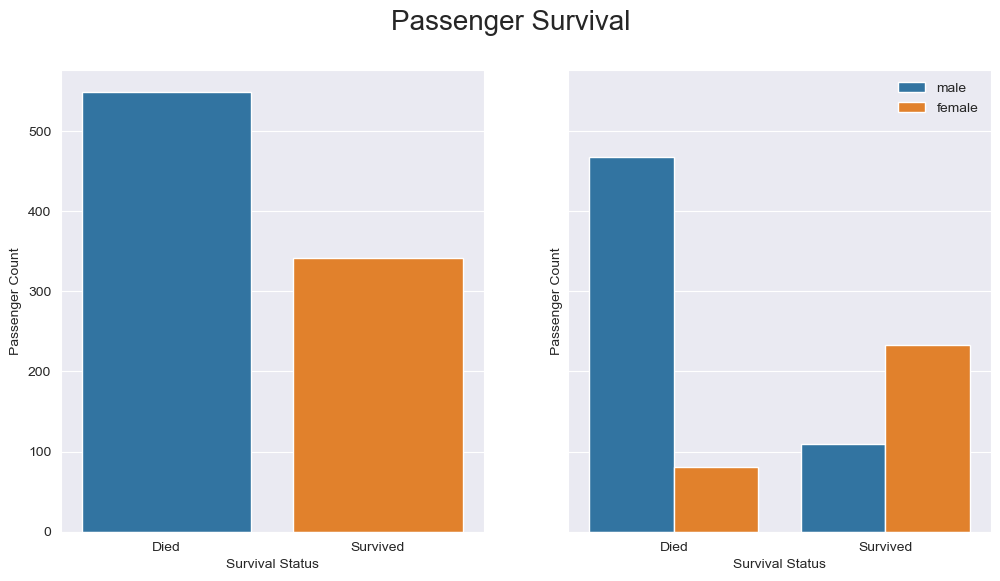

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
for i in range(2):
    if i == 0:
        sns.countplot(data=train, x="Survived", ax=ax[i])
    else:
        sns.countplot(data=train, x="Survived", hue="Sex", ax=ax[i])
    ax[i].set_xticks([0, 1], ["Died", "Survived"])
    ax[i].set_xlabel("Survival Status")
    ax[i].set_ylabel("Passenger Count")
    
fig.suptitle("Passenger Survival", size=20)
plt.legend(frameon=False)
plt.show()

I see that a majority of the passengers died. Of those that died, males dominated whereas for those that survived, females where the majority. I'd now want to know the survival and death percentages. 

In [91]:
def survival_percent(data):
    for status in [0, 1]:
        total_passengers = len(data)
        
        # First we look at those that died.
        if status == 0:
            died_count = data[data["Survived"]==status]["Survived"].count()
            died_gender_count = data[data["Survived"]==status].groupby("Sex")["Survived"].count()
            
            died_percent = np.round((died_count/total_passengers)*100)
            male_percent = np.round((died_gender_count["male"]/died_count)*100)
            female_percent = np.round((died_gender_count["female"]/died_count)*100)
            
            print(f"{died_percent}% of the passengers died.")
            print(f"Of those that died, {male_percent}% were males and {female_percent}% were females.")
            print(f"{'-'*60}")
        # Thereafter, we look at survivors.
        else:
            survived_count = data["Survived"].sum() # Works because survived is represented as 1.
            survived_gender_count = data.groupby("Sex")["Survived"].sum()
            
            survived_percent = np.round((survived_count/total_passengers)*100)
            male_percent = np.round((survived_gender_count["male"]/survived_count)*100)
            female_percent = np.round((survived_gender_count["female"]/survived_count)*100)
            
            print(f"{survived_percent}% of the passengers survived.")
            print(f"Of those that survived, {male_percent}% were males and {female_percent}% were females.")
            
    
survival_percent(train)

62.0% of the passengers died.
Of those that died, 85.0% were males and 15.0% were females.
------------------------------------------------------------
38.0% of the passengers survived.
Of those that survived, 32.0% were males and 68.0% were females.


Clearly, females had the better odds.

#### Target Distribution.

##### Distribution in continous variables.

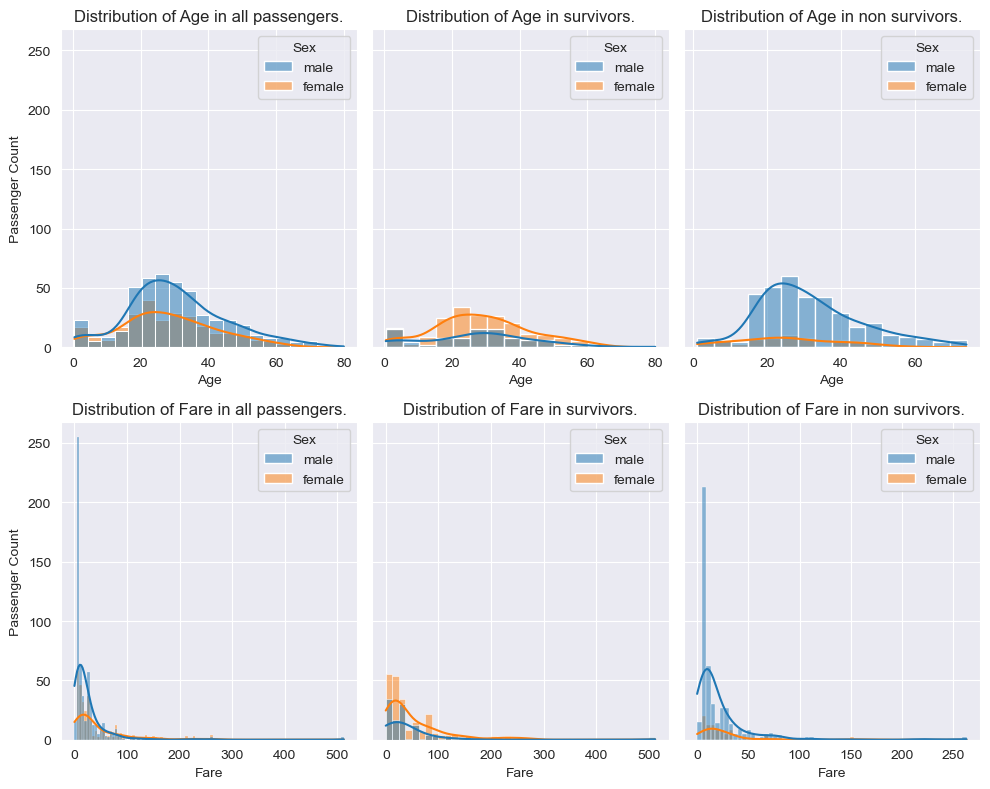

In [147]:
feature = ["Age", "Fare"]

fig, ax = plt.subplots(2,3, figsize=(10, 8), sharey=True)
for i, feat in enumerate(feature):
    # Shows distribution of target in age or fare
    sns.histplot(data=train, 
                 x=feat,
                 hue="Sex", 
                 hue_order=["male", "female"], 
                 kde=True, 
                 ax=ax[i, 0])
    sns.histplot(data=train[train["Survived"]==1], 
                 x=feat, 
                 hue="Sex", 
                 hue_order=["male", "female"], 
                 kde=True, 
                 ax=ax[i, 1])
    sns.histplot(data=train[train["Survived"]==0], 
                 x=feat, 
                 hue="Sex", 
                 hue_order=["male", "female"], 
                 kde=True, 
                 ax=ax[i, 2])
    ax[i, 0].set_ylabel("Passenger Count") 
    ax[i, 0].set_title(f"Distribution of {feat} in all passengers.")
    ax[i, 1].set_title(f"Distribution of {feat} in survivors.")
    ax[i, 2].set_title(f"Distribution of {feat} in non survivors.")

fig.tight_layout()
plt.show()

We see that the ages of passengers followed a mostly normal distribution. Survival was also normal for both survivors and those that died. Children had good survival rates and old people also seemed to survive. Fare is rightly skewed. Fare amounts were larger for those that survived compared to those that died. I'd like to know fare and ages for those that survived and those that perished. See below.

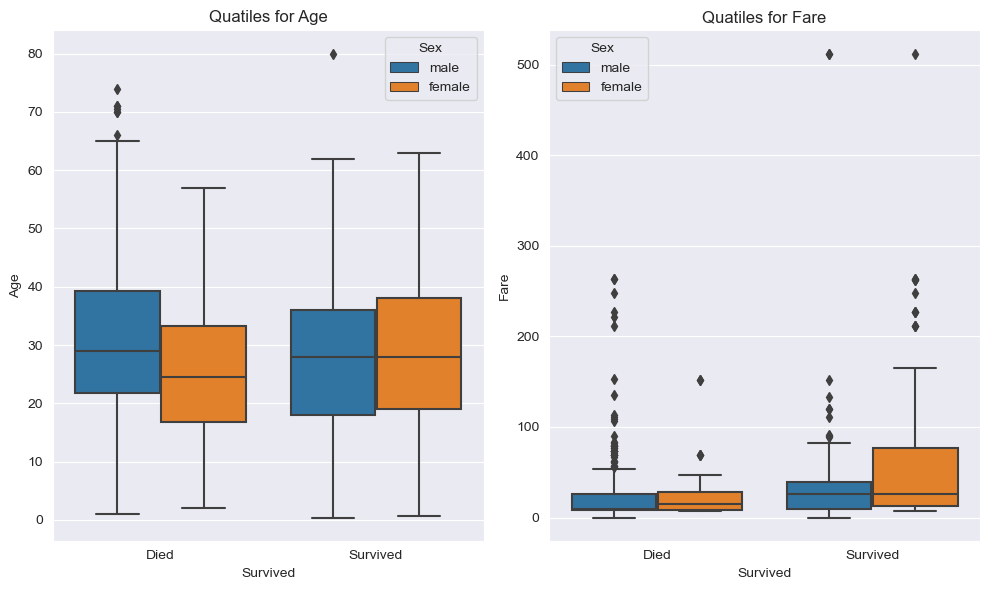

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

for i, feat in enumerate(feature):
    sns.boxplot(x="Survived", 
                y=feat, 
                hue="Sex", 
                data=train, 
                ax=ax[i])
    ax[i].set_title(f"Quatiles for {feat}")
    ax[i].set_xticks(ticks=[0, 1], labels=["Died", "Survived"])
fig.tight_layout()
plt.show()

It's interesting passengers that survived had the same values for age and fare amount between the two sexes. On the flip, for those that died, males were older compared to the females. Females that died paid more fare amounts compared to males that died. Also, it's worth mentioning passengers that survived paid more fares than those that died. Fare has alot of outliers as well. 

##### Distribution in categorical variables.

## Missing Values

While filling missing values, it's best to use the entire dataset to avoid overfitting to either the train or test data.

In [7]:
df_all = pd.concat([train, test])
df_all.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [9]:
cat_attributes = ["Name", "Sex", "Ticket", "Cabin", "Embarked"]
num_attributes = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

The following columns have null values **Age**, **Fare**, **Embarked**, and **Cabin**. 

### Age.

20% of the values in both train and test are missing values for the age column. We could use the mean to replace missing values. However, we could be a bit clever and use highly correlated columns to help in this endevour.

In [13]:
corr_matrix = df_all[num_attributes].corr()
corr_matrix["Age"].sort_values(ascending=False)

Age       1.000000
Fare      0.178740
Parch    -0.150917
SibSp    -0.243699
Pclass   -0.408106
Name: Age, dtype: float64

The highest correlation is with passenger class which is a negative correlation. We can use this column to help fill the null values in age. Before we start that, let's check if sex ages within the different passenger classes was the same and if not sex will also be used to calculate mean age. 

In [15]:
for pclass in df_all["Pclass"].unique():
    female_mean = np.floor(df_all[(df_all["Pclass"]==pclass) & (df_all["Sex"]=="female")]["Age"].mean())
    male_mean = np.floor(df_all[(df_all["Pclass"]==pclass) & (df_all["Sex"]=="male")]["Age"].mean())
    
    print(f"In passenger class {pclass}, the mean age of females was {female_mean} whereas for males was {male_mean}.")

In passenger class 3, the mean age of females was 22.0 whereas for males was 25.0.
In passenger class 1, the mean age of females was 37.0 whereas for males was 41.0.
In passenger class 2, the mean age of females was 27.0 whereas for males was 30.0.


Males were generally older across the different passenger classes.

In [17]:
df_all["Age"] = df_all.groupby(["Sex", "Pclass"])["Age"].transform(lambda x: x.fillna(np.floor(x.mean())))

### Fare.

Only one passenger (Storey, Mr. Thomas) doesn't have value for fare.

In [20]:
df_all[pd.isnull(df_all["Fare"])]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Since there is only one null, we can try to be as precise as possible while guessing what this value might have being.

In [22]:
replace_value = df_all[(df_all["Pclass"]==3)&
                   (df_all["Sex"]=="male")&
                   (df_all["SibSp"]==0)&
                   (df_all["Parch"]==0)&
                   (df_all["Embarked"]=="S")&
                   (df_all["Age"]>=60)]["Fare"].mean()
df_all["Fare"] = df_all["Fare"].fillna(replace_value)

### Embarked.

In [24]:
df_all[pd.isnull(df_all["Embarked"])]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


These people have the same ticket suggesting that they travelled together and therefore embarked from the same location. From the Gunes Evitan's notebook, using a simple google search, he found that both passengers, embarked from Southampton. Miss. Amelie was Mrs. George Maid. (I confirmed this information with a Google search of my own.)

In [26]:
df_all["Embarked"] = df_all["Embarked"].fillna("S")

### Cabin.

We extract the first letter of cabin and replace null values with M.

In [29]:
df_all["Deck"] = df_all["Cabin"].transform(lambda x: x[0] if pd.notnull(x) else "M")
df_all.drop("Cabin", axis=1, inplace=True)

Here we replace nulls with M because it's hard to use other features to help with replacement. Also, we extract we extract the first letter of the Cabin column as this represents the deck each passenger was on (again Gunes Evitan's notebook to the rescue). 

In [31]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1309 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1309 non-null   float64
 9   Embarked  1309 non-null   object 
 10  Deck      1309 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


We see that the only column with nulls is survived which is our target column.

In [33]:
train = df_all.loc[train.index]
test = df_all.loc[test.index]

del df_all

## EDA

### Visualizing Deck column.

Let's start by viewing passenger class distribution in each deck.

In [37]:
decks_ = ["A", "B", "C", "D", "E", "F", "G", "T", "M"]

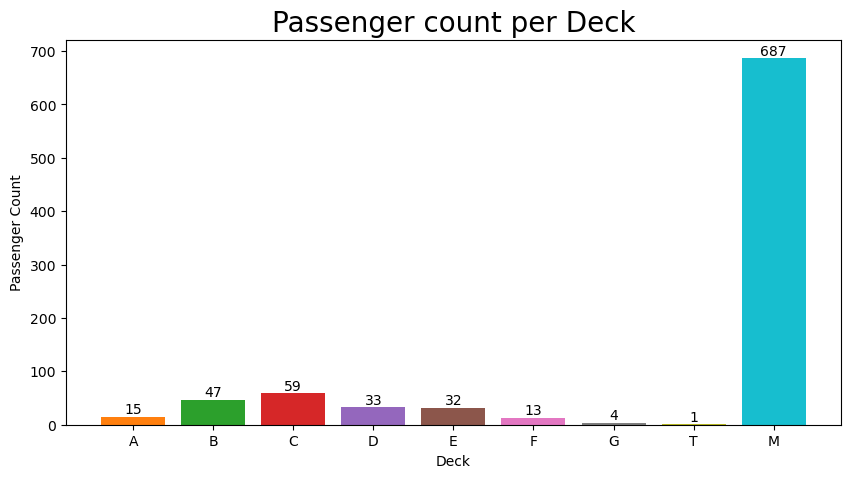

In [38]:
deck_population = []
for deck in decks_:
    population = train[train["Deck"]==deck]["Survived"].count()
    deck_population.append(population)
    
fig, ax = plt.subplots(figsize=(10,5))
rect = ax.bar(decks_, deck_population, color=["C1","C2", "C3", "C4","C5", "C6","C7","C8", "C9"])
ax.bar_label(rect)
ax.set_title("Passenger count per Deck",size=20)
ax.set_xlabel("Deck")
ax.set_ylabel("Passenger Count")
plt.show()

In [39]:
deck_dist = np.zeros((9, 3))

# We fill the matrix with the passenger distributions.
for i in range(len(decks_)):
    pclass_total = train[train["Deck"]==decks_[i]]["Pclass"].count()
    pclass_dist = train[train["Deck"]==decks_[i]].groupby("Pclass")["Pclass"].count()
    for pclass, pclass_count in pclass_dist.items():
        deck_dist[i, pclass-1] = pclass_count/pclass_total

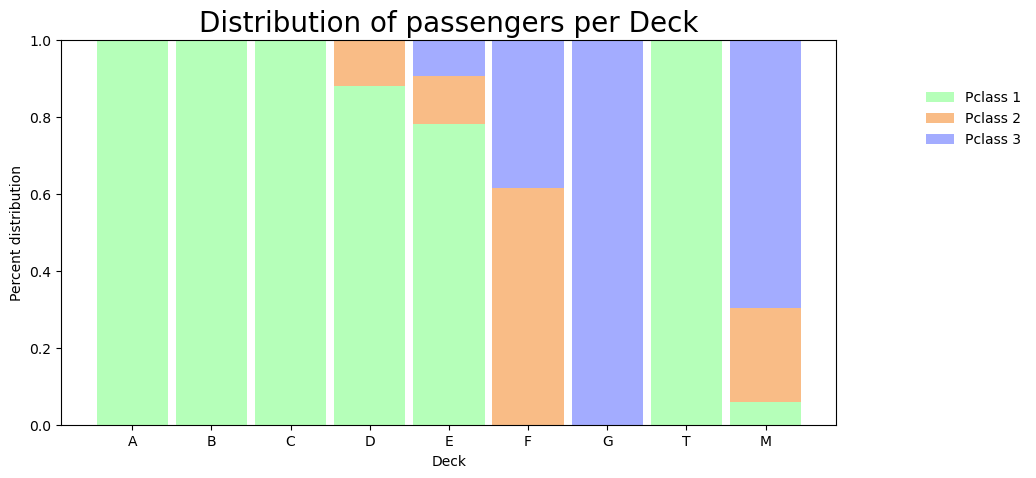

In [40]:
fig, ax = plt.subplots(figsize=(10,5))

width = 0.9
ax.bar(decks_, deck_dist[:, 0], color='#b5ffb9', width=width, label="Pclass 1")
ax.bar(decks_, deck_dist[:, 1], bottom=deck_dist[:, 0], color='#f9bc86', width=width, label="Pclass 2")
ax.bar(decks_, deck_dist[:, 2], bottom=deck_dist[:, 0] + deck_dist[:, 1], color='#a3acff', width=width, label="Pclass 3")
ax.legend(loc="upper left", bbox_to_anchor=(1.1, 0.9), frameon=False)
ax.set_title("Distribution of passengers per Deck", size=20)
ax.set_xlabel("Deck")
ax.set_ylabel("Percent distribution")

plt.show()

In [41]:
deck_survival = np.zeros((9, 2))

for i in range(len(decks_)):
    total_passenger_deck = train[train["Deck"]==decks_[i]]["Survived"].count()
    survived_deck = train[train["Deck"]==decks_[i]]["Survived"].sum() # Because we're counting number of 1.
    died_deck = train[(train["Deck"]==decks_[i])&(train["Survived"]==0)]["Survived"].count()
    deck_survival[i, 0] = survived_deck/total_passenger_deck
    deck_survival[i, 1] = died_deck/total_passenger_deck

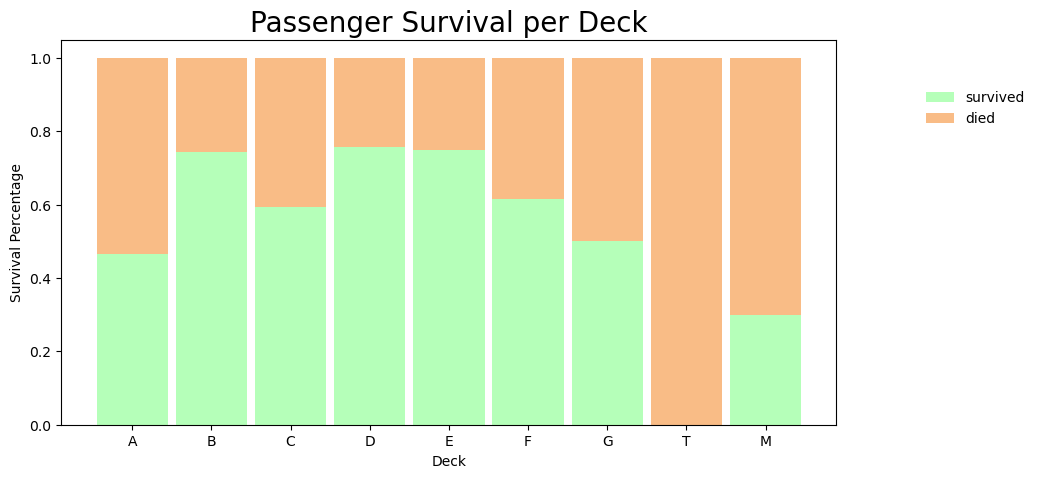

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))

width = 0.9
ax.bar(decks_, deck_survival[:, 0], color='#b5ffb9', width=width, label="survived")
ax.bar(decks_, deck_survival[:, 1], color='#f9bc86', bottom=deck_survival[:,0], width=width, label="died")
ax.legend(loc="upper left", bbox_to_anchor=(1.1, 0.9), frameon=False)
ax.set_title("Passenger Survival per Deck", size=20)
ax.set_xlabel("Deck")
ax.set_ylabel("Survival Percentage")
plt.show()

### Target Variable

#### Survival Count

#### Distribution of Target in other features

##### Continous Variables

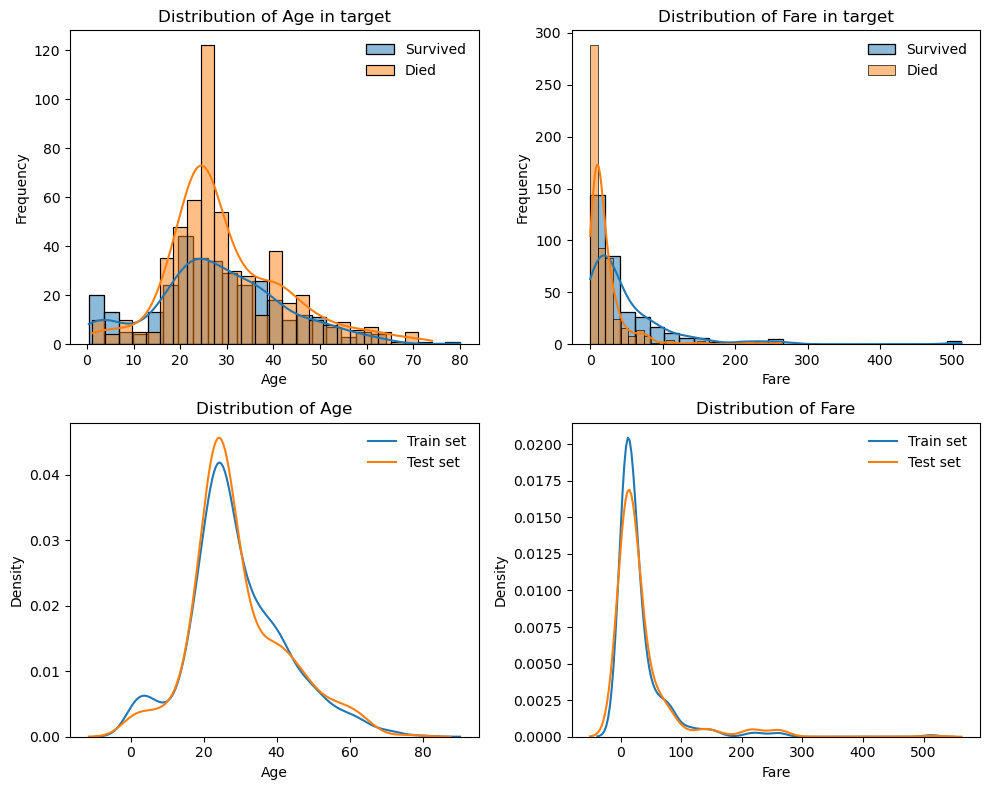

##### Categorical Variables

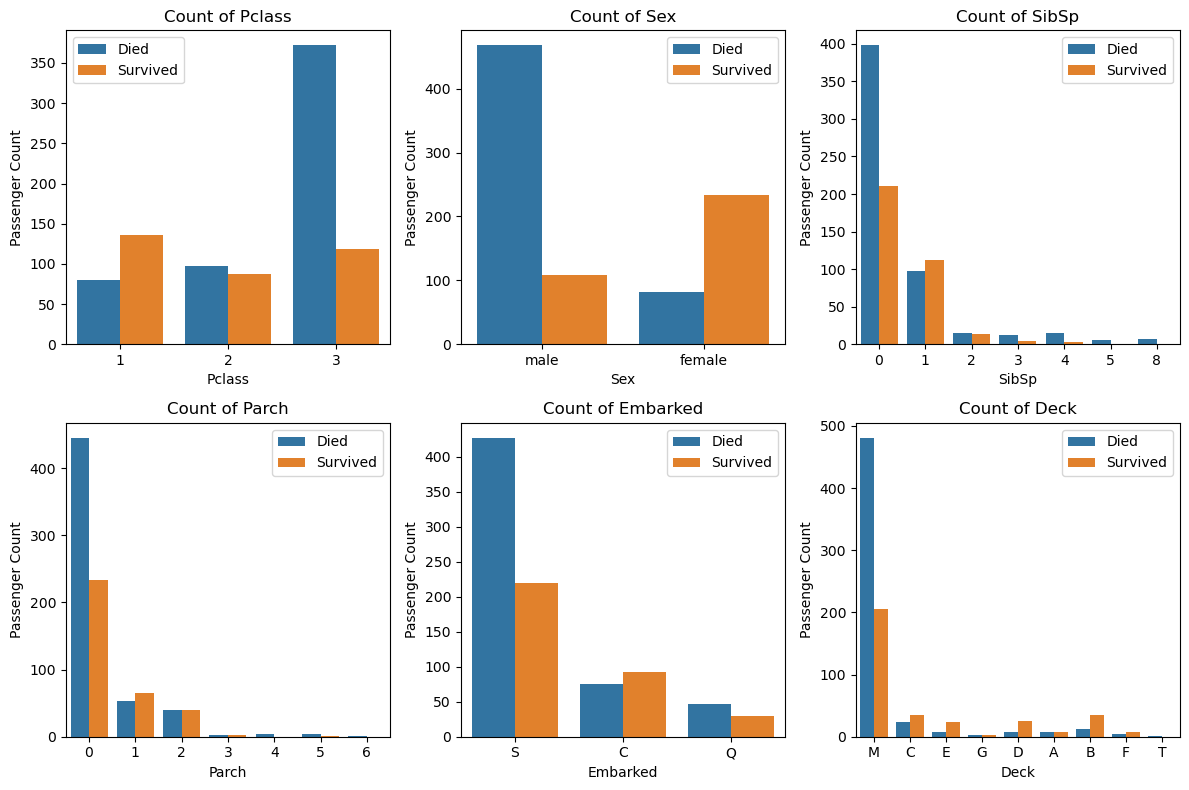

In [51]:
cat_attributes = ["Pclass", "Sex", "SibSp", "Parch", "Embarked", "Deck"]

fig, ax = plt.subplots(2, 3, figsize=(12,8))
for i, feat in enumerate(cat_attributes, 1):
    plt.subplot(2,3,i)
    sns.countplot(data=train, x=feat, hue="Survived")
    plt.title(f"Count of {feat}")
    plt.legend(["Died", "Survived"])
    plt.ylabel("Passenger Count")
    
fig.tight_layout()
plt.show()

## Feature Engineering

### Categorizing Continous Variables. 

Let's start with age. Survival and Death seem to be normally distributed. Binning this feature will help use focus on individual groups.

In [55]:
bins = [0, 12, 19, 27, 40, 60, 100]
labels = ["Children", "Teens", "Youths", "Adults", "Old Adults", "Seniors"]

train["Age"] = pd.cut(train["Age"], bins=bins, labels=labels, include_lowest=True)

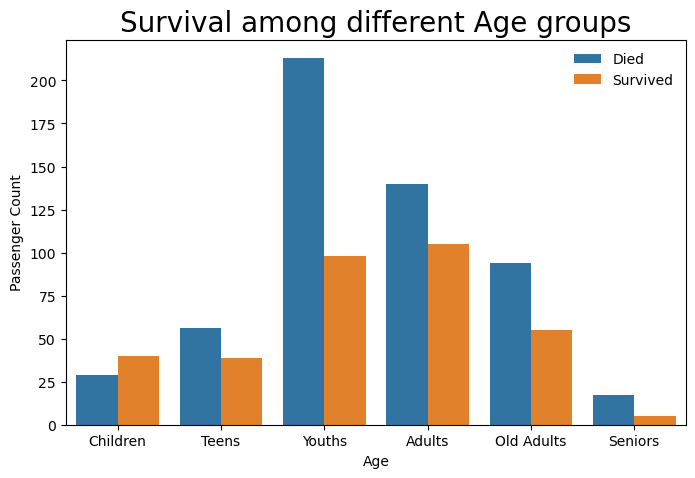

In [56]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=train, x="Age", hue="Survived", ax=ax)
ax.legend(["Died", "Survived"], frameon=False)
ax.set_title("Survival among different Age groups", size=20)
ax.set_ylabel("Passenger Count")
plt.show()

In [57]:
bins = [0, 7.5, 8, 14.5, 32, 80, 513]
labels = ["Cheap", "Affordable", "Below Average", "Average", "Above Average", "Expensive"]

train["Fare"] = pd.cut(train["Fare"], bins=bins, labels=labels, include_lowest=True)

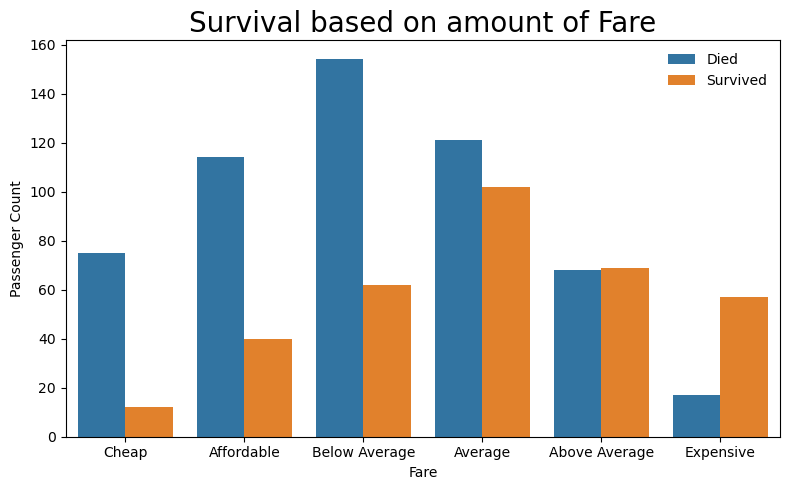

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=train, x="Fare", hue="Survived", ax=ax)
ax.legend(["Died", "Survived"], frameon=False)
ax.set_title("Survival based on amount of Fare", size=20)
ax.set_ylabel("Passenger Count")
fig.tight_layout()
plt.show()

### Relationships

In [60]:
train["Relationships"] = train["SibSp"] + train["Parch"]

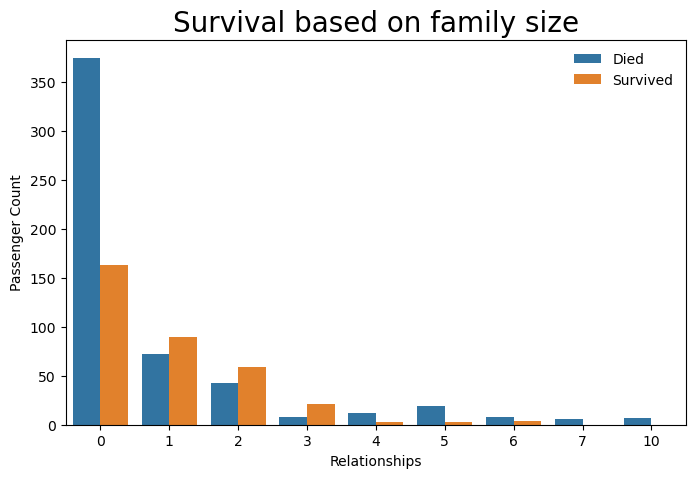

In [61]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(data=train, x="Relationships", hue="Survived", ax=ax)
ax.legend(["Died", "Survived"], frameon=False)
ax.set_title("Survival based on family size", size=20)
ax.set_ylabel("Passenger Count")
plt.show()

In [62]:
bins = [0, 1, 4, 6, 11]
labels = ["Alone", "Small", "Average", "Large"]

train["Relationships"] = pd.cut(train["Relationships"], bins=bins, labels=labels, right=False)

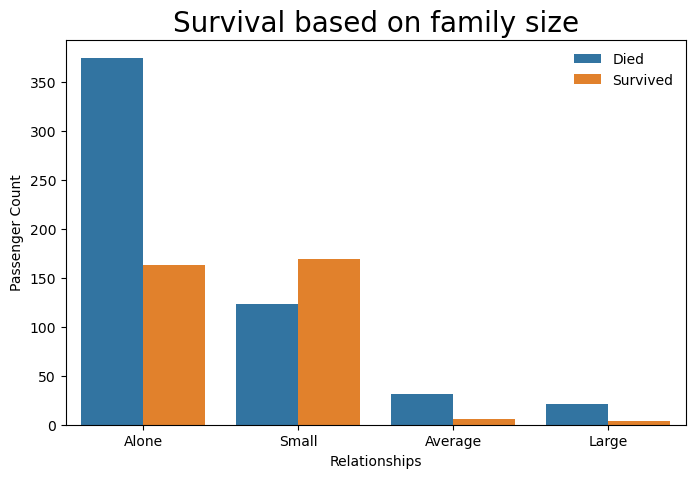

In [97]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(data=train, x="Relationships", hue="Survived", ax=ax)
ax.legend(["Died", "Survived"], frameon=False)
ax.set_title("Survival based on family size", size=20)
ax.set_ylabel("Passenger Count")
plt.show()

### Title and Married

In [142]:
train["Title"] = train["Name"].transform(lambda x: x.split(", ")[1].split(".")[0])
train["Title_Group"] = train["Title"]
train["Title_Group"] = train["Title_Group"].replace({'Miss': 'Miss/Mrs/Ms', 
                                                     'Mrs': 'Miss/Mrs/Ms',
                                                     'Ms': 'Miss/Mrs/Ms', 
                                                     'Mlle': 'Miss/Mrs/Ms', 
                                                     'Lady': 'Miss/Mrs/Ms', 
                                                     'Mme': 'Miss/Mrs/Ms', 
                                                     'the Countess': 'Miss/Mrs/Ms', 
                                                     'Dona': 'Miss/Mrs/Ms', 
                                                     'Dr': 'Dr/Military/Noble/Clergy', 
                                                     'Col': 'Dr/Military/Noble/Clergy', 
                                                     'Major': 'Dr/Military/Noble/Clergy', 
                                                     'Jonkheer': 'Dr/Military/Noble/Clergy', 
                                                     'Capt': 'Dr/Military/Noble/Clergy', 
                                                     'Sir': 'Dr/Military/Noble/Clergy', 
                                                     'Don': 'Dr/Military/Noble/Clergy', 
                                                     'Rev': 'Dr/Military/Noble/Clergy'})

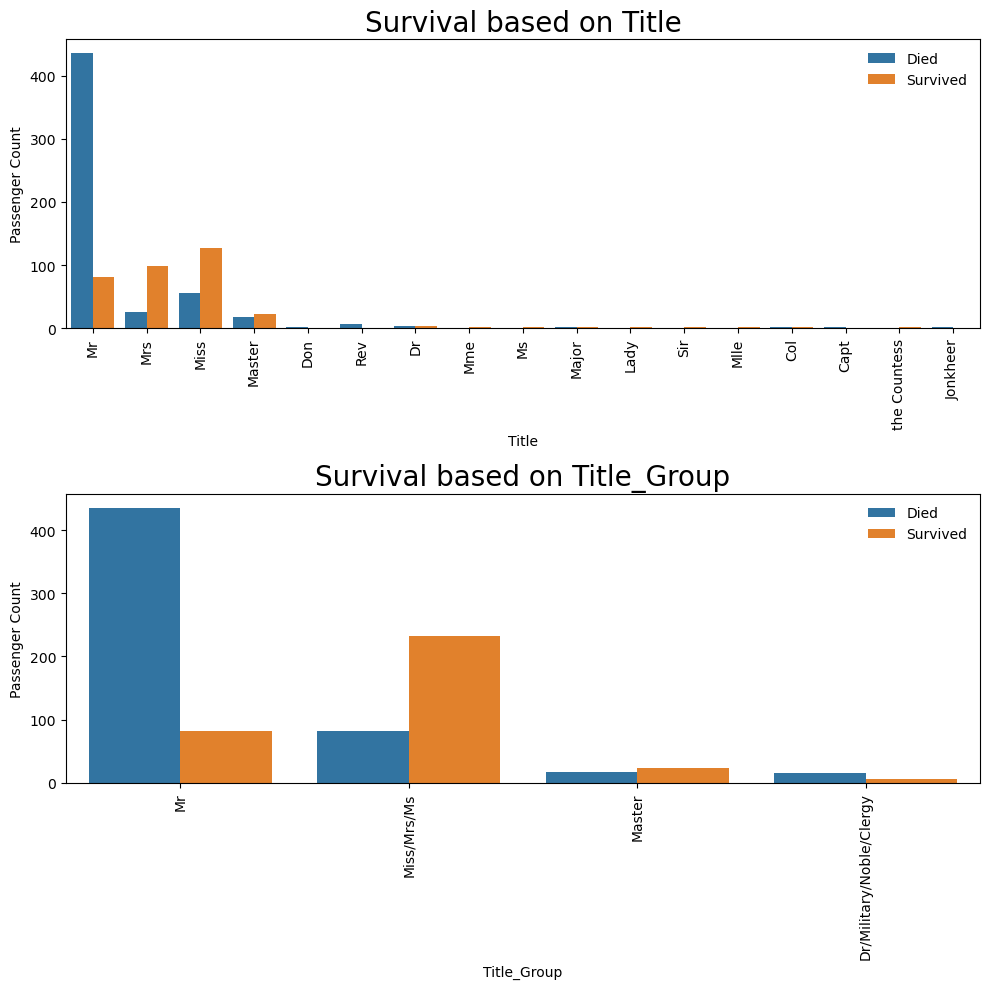

In [148]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
feature = ["Title", "Title_Group"]
for i, feat in enumerate(feature):
    sns.countplot(data=train, x=feat, hue="Survived", ax=ax[i])
    ax[i].legend(["Died", "Survived"], frameon=False)
    ax[i].set_title(f"Survival based on {feat}", size=20)
    ax[i].set_ylabel("Passenger Count")
    ax[i].tick_params(axis="x", rotation=90)
fig.tight_layout()
plt.show()